In [1]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "study"
cell_type_key = 'cell_type'

# Loading four Toy datasets and data preparation

In [4]:
adata = sc.read("./data/panorama/panorama_count.h5ad")
adata

AnnData object with n_obs × n_vars = 122816 × 2000 
    obs: 'batch', 'cell_type', 'study'

## Number of cells in each batch

In [5]:
adata.obs[cell_type_key].value_counts()

Macrophage                  32991
PBMC T cells                18006
PBMC CD4 T cells            10706
Jurkat                       9225
Neuron                       9032
PBMC CD56+ NK                6978
PBMC CD14+ monocyte          4905
Pancreas Beta                4765
Pancreas Alpha               4704
293t                         4490
PBMC CD8 T cells             3990
PBMC CD19+ B cells           3397
Pancreas Ductal              2104
Hsc MEP                      1394
Hsc GMP                      1183
Pancreas Delta               1041
Pancreas Endothelial          836
Pancreas Acinar               713
Pancreas Gamma                637
Hsc CMP                       590
Pancreas Stellate             561
Pancreas Beta(ER stress)      320
Pancreas Unkonwn              240
Hsc Unknown                     8
Name: cell_type, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [6]:
adata = surgeon.utils.normalize(adata, 
                                  filter_min_counts=False, 
                                  normalize_input=False, 
                                  size_factors=True,
                                  logtrans_input=True,
                                  n_top_genes=5000,
                                 )

In [7]:
adata

AnnData object with n_obs × n_vars = 122816 × 2000 
    obs: 'batch', 'cell_type', 'study', 'n_counts', 'size_factors'

## Train/Test Split

In [8]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata, 0.85)

In [9]:
train_adata.shape, valid_adata.shape

((104393, 2000), (18423, 2000))

In [10]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_labels = len(train_adata.obs[cell_type_key].unique().tolist())

# Create & Train model with training data

In [11]:
network = surgeon.archs.NNClassifier(x_dimension=train_adata.shape[1], 
                                     z_dimension=40,
                                     cvae_network=None,
                                     n_labels=n_labels,
                                     lr=0.001,
                                     alpha=0.001,
                                     eta=1.0,
                                     clip_value=1e6,
                                     model_path="./models/NNClassifier/scratch/",
                                     dropout_rate=0.2,
                                     )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1024000     data[0][0]                       
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512)          2048        first_layer[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyR

## Training the network

In [12]:
network.train(train_adata,
              valid_adata, 
              cell_type_key=cell_type_key,
              n_epochs=10,
              batch_size=32, 
              early_stop_limit=15,
              lr_reducer=10, 
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 104393 samples, validate on 18423 samples
Epoch 1/10
 - 11s - loss: 0.2820 - acc: 0.9017 - val_loss: 0.1867 - val_acc: 0.9366
Epoch 2/10



KeyboardInterrupt



In [14]:
latent_adata = network.to_latent(adata)
latent_adata

AnnData object with n_obs × n_vars = 122816 × 40 
    obs: 'batch', 'cell_type', 'study', 'n_counts', 'size_factors'

In [15]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

saving figure to file ./figures/umap_latent_MLP.pdf


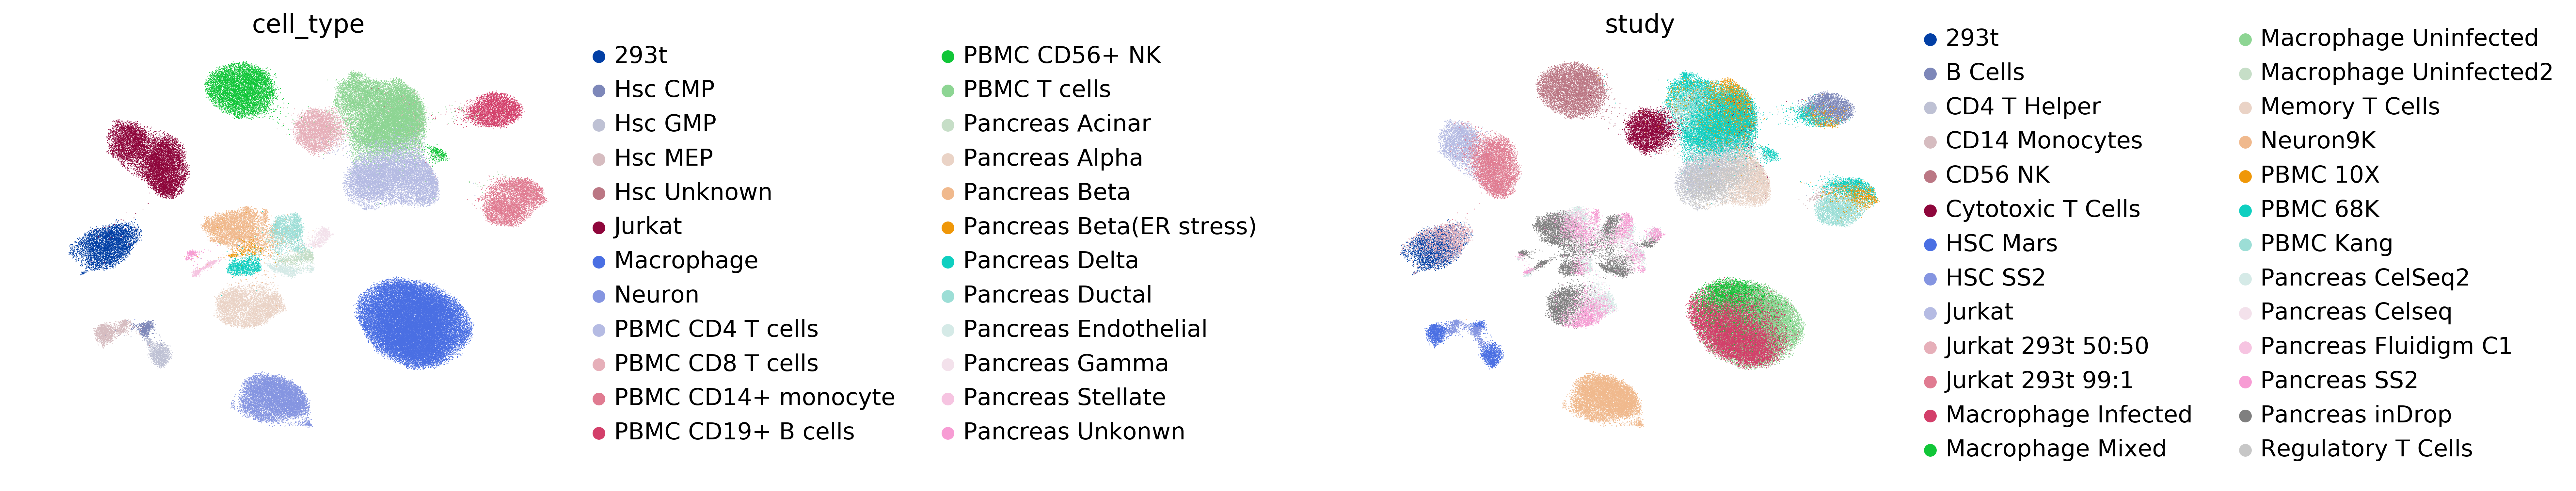

In [18]:
sc.pl.umap(latent_adata, color=[cell_type_key, condition_key], wspace=1.3, frameon=False,
           save="_latent_MLP.pdf")